In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels import api as sm
from statsmodels.graphics import tsaplots 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
pd.options.display.float_format='{:.2f}'.format

In [3]:
data_all=pd.read_csv('AirPassengers.csv')
display(data_all.head(20))

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [4]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


Пропусков нет

In [5]:
data_all=data_all.rename(columns={'#Passengers':'Passengers'})

In [6]:
data_all['Month']=pd.to_datetime(data_all['Month'], format='%Y-%m')
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [7]:
data_all.set_index('Month', inplace=True)

In [8]:
data_all.index.is_monotonic_increasing

True

Данные монотонно возрастают

In [9]:
data=data_all['1952':'1957']
print(data.index.min(), data.index.max())

1952-01-01 00:00:00 1957-12-01 00:00:00


C:\Users\Dev\AppData\Local\Temp\ipykernel_5228\2506293565.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


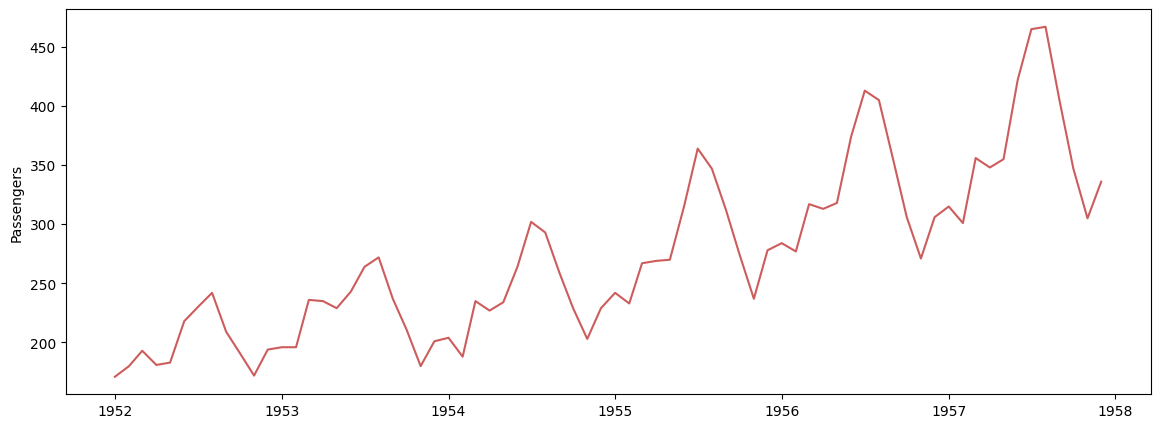

In [11]:
fig, ax = plt.subplots(1,1,figsize=[14,5])
ax.plot(data['Passengers'], c='indianred')
ax.set_ylabel('Passengers')
fig.show()

Тренд на увеличение количества пасажиров и увеличение размаха сезонности

In [13]:
data_rolling_mean=data[['Passengers']].rolling(12).mean()

C:\Users\Dev\AppData\Local\Temp\ipykernel_5228\2707032154.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


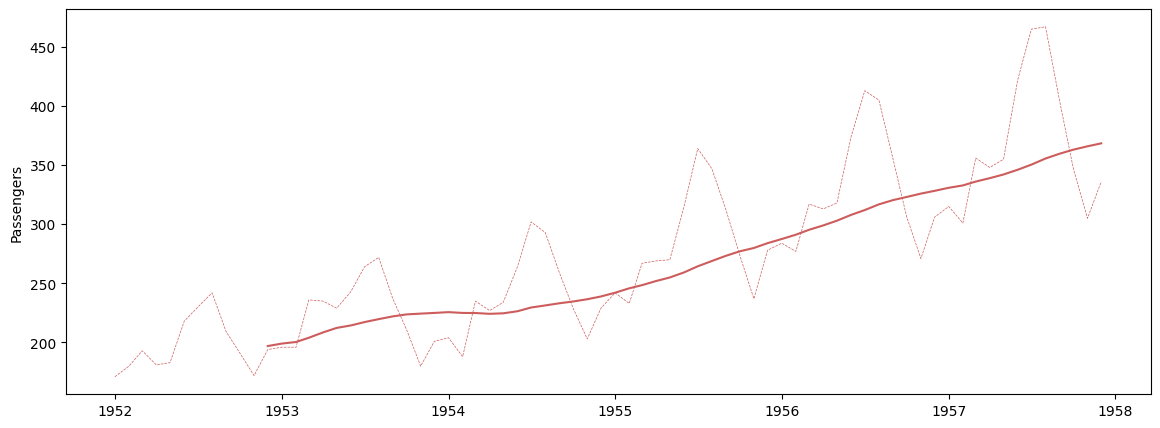

In [15]:
fig, ax = plt.subplots(1,1, figsize=[14,5])
ax.plot(data['Passengers'], c='indianred', linewidth=0.5 , linestyle='--')
ax.plot(data_rolling_mean['Passengers'], c='indianred', label='Revenure_per')
ax.set_ylabel('Passengers')
fig.show()

In [16]:
decomposed=seasonal_decompose(data['Passengers'])


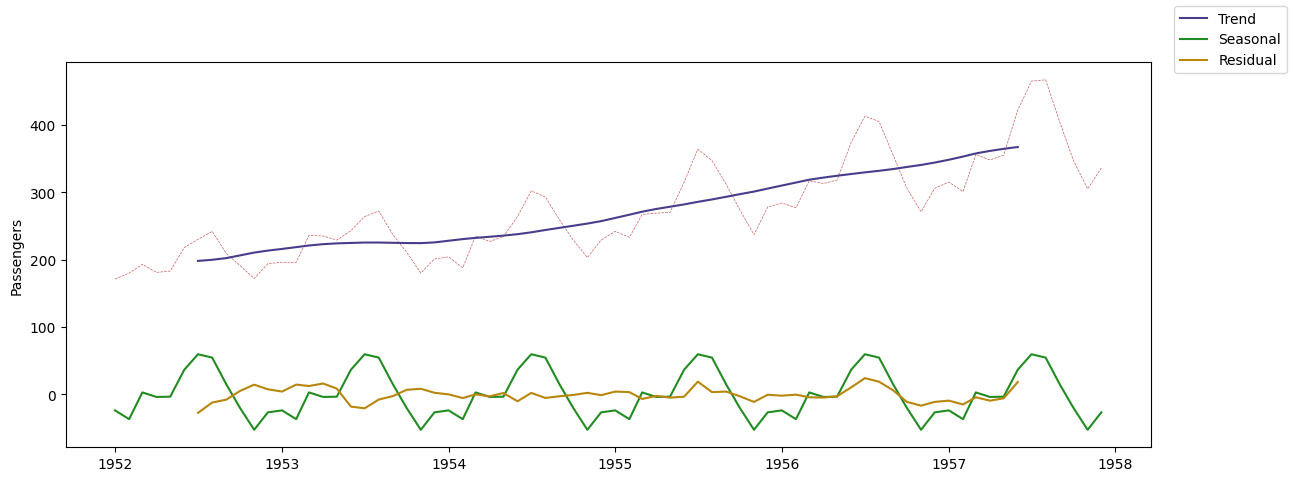

In [17]:
fig, ax = plt.subplots(1,1, figsize=[14,5])
ax.plot(data['Passengers'], c='indianred', linewidth=0.5, linestyle='--')
ax.plot(decomposed.trend, c='darkslateblue', label='Trend')
ax.plot(decomposed.seasonal, c='forestgreen', label='Seasonal')
ax.plot(decomposed.resid, c='darkgoldenrod', label='Residual')
ax.set_ylabel('Passengers')
fig.legend()

Тренд имеет растущий характер, сезонность есть, цикл 1 год. Ряд не стационарен

C:\Users\Dev\AppData\Local\Temp\ipykernel_5228\3176732313.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


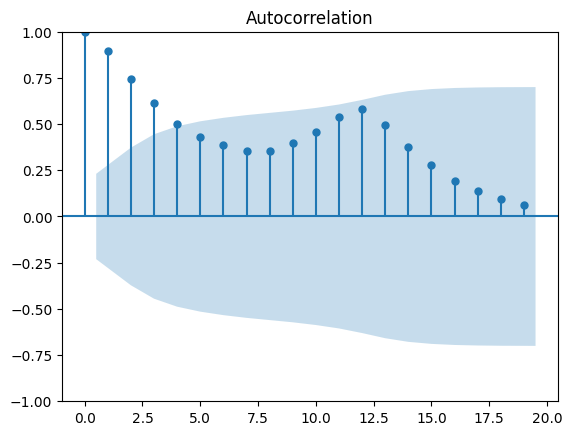

In [18]:
fig=tsaplots.plot_acf(data['Passengers'])
fig.show()

У сдвига 12 мес. самая большая автокореляция.

C:\Users\Dev\AppData\Local\Temp\ipykernel_5228\2973892423.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


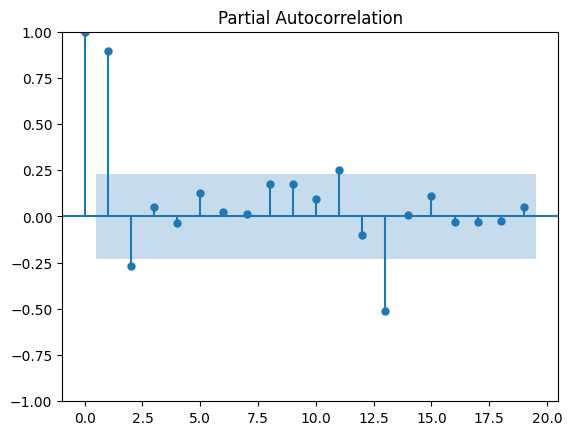

In [37]:
fig=tsaplots.plot_pacf(data['Passengers'])
fig.show()

In [19]:
def make_features(data, max_lag, max_rolling_mean_size):
    data['year']=data.index.year
    data['month']=data.index.month
    data['quarter']=data.index.quarter

    for lag in range(1, max_lag+1):
        data[f'lag_{lag}']=data['Passengers'].shift(lag)
    
    for rolling_mean_size in range(1, max_rolling_mean_size+1):
        data[f'rolling_mean_{rolling_mean_size}']=data['Passengers'].rolling(rolling_mean_size).mean()
        data[f'rolling_mean_{rolling_mean_size}']=data[f'rolling_mean_{rolling_mean_size}'].shift(rolling_mean_size)

    return data

In [20]:
data_with_features=make_features(data[['Passengers']].copy(),6,6)
data_with_features.head(10)

,Passengers,year,month,quarter,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean_1,rolling_mean_2,rolling_mean_3,rolling_mean_4,rolling_mean_5,rolling_mean_6
Month,,,,,,,,,,,,,,,,
1952-01-01,171,1952,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952-02-01,180,1952,2,1,171.00,NaN,NaN,NaN,NaN,NaN,171.00,NaN,NaN,NaN,NaN,NaN
1952-03-01,193,1952,3,1,180.00,171.00,NaN,NaN,NaN,NaN,180.00,NaN,NaN,NaN,NaN,NaN
1952-04-01,181,1952,4,2,193.00,180.00,171.00,NaN,NaN,NaN,193.00,175.50,NaN,NaN,NaN,NaN
1952-05-01,183,1952,5,2,181.00,193.00,180.00,171.00,NaN,NaN,181.00,186.50,NaN,NaN,NaN,NaN
1952-06-01,218,1952,6,2,183.00,181.00,193.00,180.00,171.00,NaN,183.00,187.00,181.33,NaN,NaN,NaN
1952-07-01,230,1952,7,3,218.00,183.00,181.00,193.00,180.00,171.00,218.00,182.00,184.67,NaN,NaN,NaN
1952-08-01,242,1952,8,3,230.00,218.00,183.00,181.00,193.00,180.00,230.00,200.50,185.67,181.25,NaN,NaN
1952-09-01,209,1952,9,3,242.00,230.00,218.00,183.00,181.00,193.00,242.00,224.00,194.00,184.25,NaN,NaN


In [22]:
train, test=train_test_split(data_with_features,shuffle=False, test_size=0.2)
train=train.dropna()

In [23]:
train_target=train['Passengers']
train_features=train.drop(['Passengers'], axis=1)
test_target=test['Passengers']
test_features=test.drop(['Passengers'],axis=1)

In [24]:
scaler=StandardScaler().fit(train_features)
train_features_norm=scaler.transform(train_features)
test_features_norm=scaler.transform(test_features)

In [25]:
model=LinearRegression()
model.fit(train_features_norm, train_target)

LinearRegression()

In [26]:
train_prediction=pd.Series(model.predict(train_features_norm))
train_prediction.index=train_features.index
test_prediction=pd.Series(model.predict(test_features_norm))
test_prediction.index=test_features.index

In [27]:
print('MAE обучающей выборки:', mean_absolute_error(train_target, train_prediction))
print('MAE тестовой выборки:', mean_absolute_error(test_target, test_prediction))

MAE обучающей выборки: 12.304108384384255
MAE тестовой выборки: 16.2496775491948


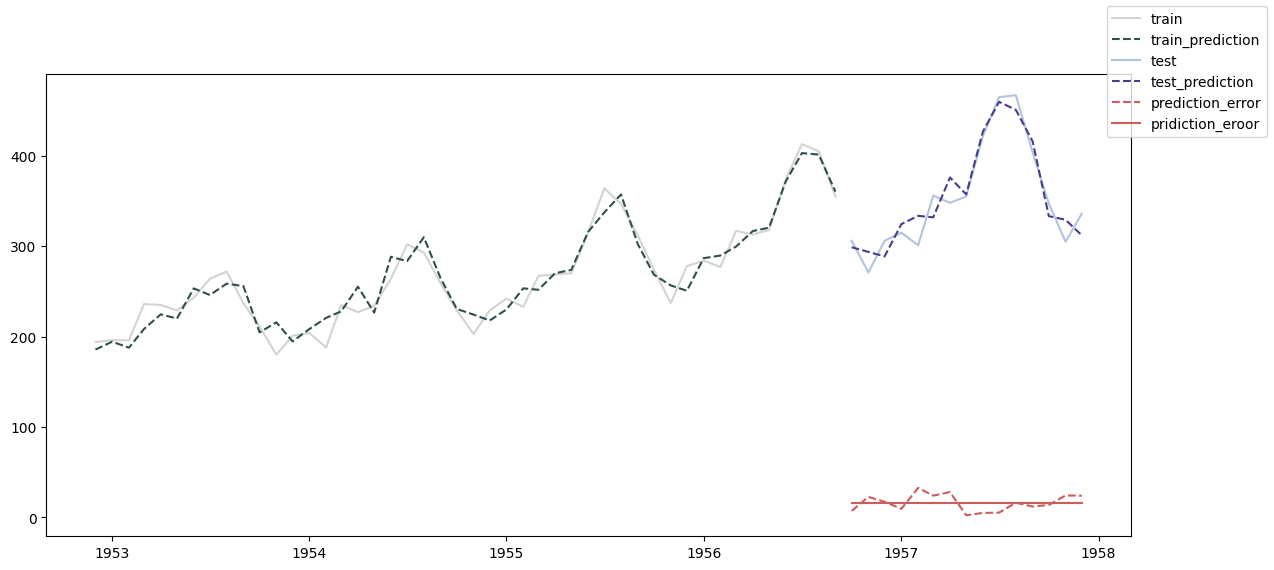

In [28]:
fig, ax = plt.subplots(1,1, figsize=[14,6])
error=abs(test['Passengers']-test_prediction)
error_mean=pd.Series([error.mean()]*error.shape[0])
error_mean.index=test.index

ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_prediction, c='darkslategrey', label='train_prediction', linestyle='dashed')
ax.plot(test_target, c="lightsteelblue", label='test')
ax.plot(test_prediction, c='darkslateblue', label='test_prediction', linestyle='dashed')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error')
ax.plot(error_mean, c='indianred',label='pridiction_eroor')
fig.legend()


In [30]:
data2=data_all['1957':'1960']
print(data2.index.min(), data2.index.max())
data2

1957-01-01 00:00:00 1960-12-01 00:00:00


,Passengers
Month,
1957-01-01,315
1957-02-01,301
1957-03-01,356
1957-04-01,348
1957-05-01,355
1957-06-01,422
1957-07-01,465
1957-08-01,467
1957-09-01,404


In [31]:

data_with_features=make_features(data2[['Passengers']].copy(), 6, 6)
data_with_features.head(10)

,Passengers,year,month,quarter,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean_1,rolling_mean_2,rolling_mean_3,rolling_mean_4,rolling_mean_5,rolling_mean_6
Month,,,,,,,,,,,,,,,,
1957-01-01,315,1957,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957-02-01,301,1957,2,1,315.00,NaN,NaN,NaN,NaN,NaN,315.00,NaN,NaN,NaN,NaN,NaN
1957-03-01,356,1957,3,1,301.00,315.00,NaN,NaN,NaN,NaN,301.00,NaN,NaN,NaN,NaN,NaN
1957-04-01,348,1957,4,2,356.00,301.00,315.00,NaN,NaN,NaN,356.00,308.00,NaN,NaN,NaN,NaN
1957-05-01,355,1957,5,2,348.00,356.00,301.00,315.00,NaN,NaN,348.00,328.50,NaN,NaN,NaN,NaN
1957-06-01,422,1957,6,2,355.00,348.00,356.00,301.00,315.00,NaN,355.00,352.00,324.00,NaN,NaN,NaN
1957-07-01,465,1957,7,3,422.00,355.00,348.00,356.00,301.00,315.00,422.00,351.50,335.00,NaN,NaN,NaN
1957-08-01,467,1957,8,3,465.00,422.00,355.00,348.00,356.00,301.00,465.00,388.50,353.00,330.00,NaN,NaN
1957-09-01,404,1957,9,3,467.00,465.00,422.00,355.00,348.00,356.00,467.00,443.50,375.00,340.00,NaN,NaN


In [32]:
data_with_features=data_with_features.dropna()
data_with_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37 entries, 1957-12-01 to 1960-12-01
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Passengers      37 non-null     int64  
 1   year            37 non-null     int32  
 2   month           37 non-null     int32  
 3   quarter         37 non-null     int32  
 4   lag_1           37 non-null     float64
 5   lag_2           37 non-null     float64
 6   lag_3           37 non-null     float64
 7   lag_4           37 non-null     float64
 8   lag_5           37 non-null     float64
 9   lag_6           37 non-null     float64
 10  rolling_mean_1  37 non-null     float64
 11  rolling_mean_2  37 non-null     float64
 12  rolling_mean_3  37 non-null     float64
 13  rolling_mean_4  37 non-null     float64
 14  rolling_mean_5  37 non-null     float64
 15  rolling_mean_6  37 non-null     float64
dtypes: float64(12), int32(3), int64(1)
memory usage: 4.5 KB


In [33]:
test_target=data_with_features['Passengers']
test_features=data_with_features.drop(['Passengers'], axis=1)


In [34]:
test_features_norm=scaler.transform(test_features)
test_prediction=pd.Series(model.predict(test_features_norm))
test_prediction.index=test_features.index
print('MAE отложенной выборки:', mean_absolute_error(test_target, test_prediction))

MAE отложенной выборки: 28.76791752733791


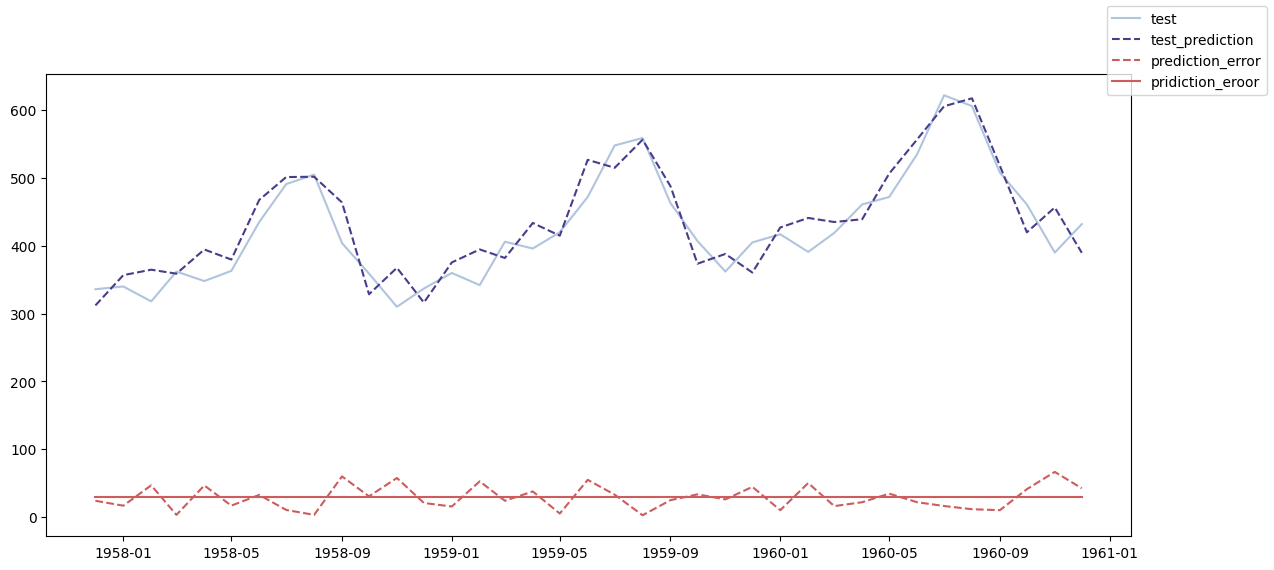

In [36]:
fig, ax = plt.subplots(1,1, figsize=[14,6])
error=abs(test_target -test_prediction)
error_mean=pd.Series([error.mean()]*error.shape[0])
error_mean.index=test_target.index
ax.plot(test_target, c="lightsteelblue", label='test')
ax.plot(test_prediction, c='darkslateblue', label='test_prediction', linestyle='dashed')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error')
ax.plot(error_mean, c='indianred',label='pridiction_eroor')
fig.legend()
